In [1]:
#Utils

import torch
import random
import copy
from torch.functional import F
from collections import deque
import numpy as np


def extract_data(sample, device):
    states_tuple = np.array([_[0] for _ in sample])
    actions_tuple = np.array([_[1] for _ in sample])
    next_states_tuple = np.array([_[2] for _ in sample])
    rewards_tuple = np.float32(np.array([_[3] for _ in sample]))

    compressed_states = torch.from_numpy(states_tuple).requires_grad_()
    compressed_actions = torch.from_numpy(actions_tuple).requires_grad_()
    compressed_next_states = torch.from_numpy(next_states_tuple)
    compressed_rewards = torch.from_numpy(rewards_tuple)

    return F.normalize(compressed_states).to(device), F.normalize(compressed_actions).to(device), \
           F.normalize(compressed_next_states).to(device), compressed_rewards.to(device)


class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.state = None
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([np.random.randn() for i in range(len(x))])
        self.state = x + dx
        return self.state


class ReplayBuffer:
    def __init__(self, max_length):
        self.max_length = max_length
        self.Buffer = deque(
            maxlen=self.max_length)  # The last first entry gets automatically removed when the buffer size is exceeded

    def append_memory(self, experience):
        self.Buffer.appendleft(experience)

    def sample(self, batch_size=32):
        return random.sample(self.Buffer, batch_size)

    def buf_len(self):
        return len(self.Buffer)


In [4]:
#Network

import torch.nn as nn
import torch


class ActorNet(nn.Module):
    def __init__(self, d_in, d_out, batch_size):
        super(ActorNet, self).__init__()
        self.action_vector = nn.Sequential(nn.Linear(d_in, batch_size),
                                           nn.ReLU(),
                                           nn.Linear(batch_size, batch_size),
                                           nn.ReLU(),
                                           nn.Linear(batch_size, d_out),
                                           nn.Sigmoid())

    def forward(self, x):
        return self.action_vector(x)


class CriticNet(nn.Module):
    def __init__(self, d_in, d_out, batch_size):
        super(CriticNet, self).__init__()
        self.value = nn.Sequential(nn.Linear(d_in + d_out, batch_size),
                                   nn.ReLU(),
                                   nn.Linear(batch_size, batch_size),
                                   nn.ReLU(),
                                   nn.Linear(batch_size, 1))

    def forward(self, x):
        return self.value(x)


class Actor:
    def __init__(self, n_o, n_a, batch_size):
        self.policy = ActorNet(n_o, n_a, batch_size)

    def get_action(self, state):
        return self.policy(state)


class Critic:
    def __init__(self, n_o, n_a, batch_size):
        self.value_func = CriticNet(n_o, n_a, batch_size)

    def get_state_value(self, state, action):
        x = torch.cat((state, action), dim=1)
        return self.value_func.forward(x)


def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight.data)
        nn.init.constant_(m.bias.data, 0)


Running on device: cpu


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:37<00:00,  4.19s/it]


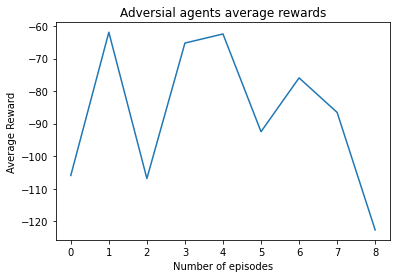

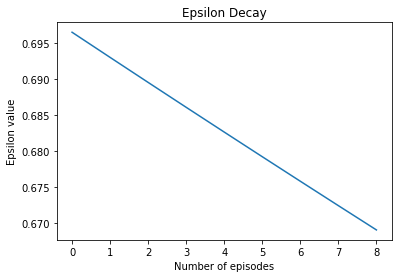

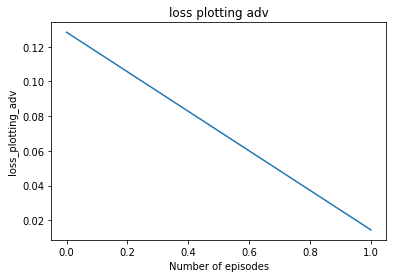

In [3]:
#Tagworld

import datetime
import time

from pettingzoo.mpe import simple_tag_v2

import copy
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

# import torch
import numpy as np


class TagWorld:
    def __init__(self):
        self.n_good = 1
        self.n_adv = 3
        self.n_obstacles = 0
        self.max_cycs = 1000
        self.continuous = True

        self.env = simple_tag_v2.env(
            num_good=self.n_good,
            num_adversaries=self.n_adv,
            num_obstacles=self.n_obstacles,
            max_cycles=self.max_cycs,
            continuous_actions=self.continuous
        )

        # parameters
        self.GAMMA = 0.99  # Discount factor
        self.ALPHA = 1e-3  # learning rate
        self.TAU = 0.001
        self.BATCH_SIZE = 32
        self.BUFFER_SIZE = 3000
        self.epsilon = 0.7
        self.decay = 0.99999
        self.max_episodes = 9
        self.max_rollout = 500

        n_inputs_good = 10
        n_inputs_adv = 12
        n_outputs = 5
        self.Noise = OUNoise(n_outputs)

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print("Running on device:", self.device)

        # initiate the networks for the agents
        # the reason why critic network use 1 as output and the unsqueeze later
        self.GoodNetActor = Actor(n_inputs_good, n_outputs, self.BATCH_SIZE)
        self.GoodNetCritic = Critic(n_inputs_good, 1, self.BATCH_SIZE)

        self.AdvNetActor = Actor(n_inputs_adv, n_outputs, self.BATCH_SIZE)
        self.AdvNetCritic = Critic(n_inputs_adv, 1, self.BATCH_SIZE)

        # Target Network
        self.GoodNetActorTarget = copy.deepcopy(self.GoodNetActor)
        self.GoodNetCriticTarget = copy.deepcopy(self.GoodNetCritic)

        self.AdvNetActorTarget = copy.deepcopy(self.AdvNetActor)
        self.AdvNetCriticTarget = copy.deepcopy(self.AdvNetCritic)

        self.AdvNetActor.policy.apply(initialize_weights)
        self.AdvNetCritic.value_func.apply(initialize_weights)
        self.AdvNetActorTarget.policy.apply(initialize_weights)
        self.AdvNetCriticTarget.value_func.apply(initialize_weights)

        # to GPU
        self.GoodNetActor.policy.to(self.device)
        self.GoodNetCritic.value_func.to(self.device)
        self.AdvNetActor.policy.to(self.device)
        self.AdvNetCritic.value_func.to(self.device)
        self.GoodNetActorTarget.policy.to(self.device)
        self.GoodNetCriticTarget.value_func.to(self.device)
        self.AdvNetActorTarget.policy.to(self.device)
        self.AdvNetCriticTarget.value_func.to(self.device)

        # Experience
        self.ReplayBufferGood = ReplayBuffer(self.BUFFER_SIZE)
        self.ReplayBufferAdv = ReplayBuffer(self.BUFFER_SIZE)

        # optimizer
        self.optim_good = torch.optim.Adam(self.GoodNetCritic.value_func.parameters(), lr=self.ALPHA)
        self.optim_adv = torch.optim.Adam(self.AdvNetCritic.value_func.parameters(), lr=self.ALPHA)

        self.env.reset()

    def train(self):
        self.env.reset()

        # Store rewards to be plotted
        rewards_good = []
        rewards_adv = []

        # Epsilon stored for plotting
        epsilon_plotting = []

        # Loss for plotting
        loss_plotting_good = []
        loss_plotting_adv = []

        for _ in tqdm(range(self.max_episodes)):
            self.env.reset()
            count = 0

            reward_good = 0
            reward_adv = 0

            output_good = 0
            output_adv = 0
            # Decay greedy epsilon
            self.epsilon = self.epsilon * self.decay

            for agent in self.env.agent_iter():
                # if count % 50 == 0:
                #     print(count)

                # action from network
                observation, agent_reward, _, _, _ = self.env.last()
                if agent == 'agent_0':
                    action = self.GoodNetActor.get_action(torch.from_numpy(observation).to(self.device))
                    action = action.cpu().detach().numpy() + self.Noise.sample()
                    action = np.float32(np.clip(action, 0, 1))
                    # print(action)

                    # agent_reward += 2 * (np.linalg.norm((observation[4], observation[5])) +
                    #                      np.linalg.norm((observation[6], observation[7])) +
                    #                      np.linalg.norm((observation[8], observation[9])))
                    # agent_reward -= min(abs(1 // (5 * np.linalg.norm((observation[0], observation[1])))), 50)
                    # reward_good = reward_good + agent_reward
                else:
                    action = self.AdvNetActor.get_action(torch.from_numpy(observation).to(self.device))
                    action = action.cpu().detach().numpy() + self.Noise.sample()
                    action = np.float32(np.clip(action, 0, 1))
                    # print(action)

                    agent_reward -= 0.5 * np.linalg.norm((observation[8], observation[9]))
                    # agent_reward -= min(abs(1 // (5 * np.linalg.norm((observation[0], observation[1])))), 50)
                    reward_adv = reward_adv + agent_reward

                # epsilon greedy, if true, replace the action above
                p = random.random()
                if p < self.epsilon:
                    action = self.env.action_space(agent).sample()
                # Decay greedy epsilon
                self.epsilon = self.epsilon * self.decay

                # Get the new state, reward, and done signal
                self.env.step(action)
                _, _, termination_new, truncation_new, _ = self.env.last()
                observation_new = self.env.observe(agent)
                reward_new = self.env.rewards[agent]

                if agent == 'agent_0':
                    pass
                #     reward_new += (np.linalg.norm((observation_new[4], observation_new[5])) +
                #                    np.linalg.norm((observation_new[6], observation_new[7])) +
                #                    np.linalg.norm((observation_new[8], observation_new[9])))
                #     reward_new -= min(abs(1 // (5 * np.linalg.norm((observation_new[0], observation_new[1])))), 50)
                else:
                    reward_new -= 0.5 * np.linalg.norm((observation[8], observation[9]))

                # store replay buffer
                experience = [observation, action, observation_new, reward_new]
                if agent == 'agent_0':
                    # different iteration or do the calculation
                    self.ReplayBufferGood.append_memory(experience)
                else:
                    self.ReplayBufferAdv.append_memory(experience)

                if termination_new or truncation_new or count > self.max_rollout:
                    break

                # run all agents in every loop
                if self.ReplayBufferAdv.buf_len() >= self.BUFFER_SIZE:
                    # sampled_experience_good = self.ReplayBufferGood.sample()
                    sampled_experience_adv = self.ReplayBufferAdv.sample(batch_size=64)

                    # Adversarial Agent
                    compressed_states_adv, compressed_actions_adv, compressed_next_states_adv, compressed_rewards_adv \
                        = extract_data(sampled_experience_adv, self.device)

                    target_action_adv = self.AdvNetActorTarget.get_action(compressed_next_states_adv)
                    target_action_adv = target_action_adv.mean(dim=1).unsqueeze(-1)
                    target_value_adv = self.AdvNetCriticTarget.get_state_value(compressed_next_states_adv,
                                                                               target_action_adv)

                    # compute targets
                    # target_v_good = compressed_rewards_good.unsqueeze(1) + self.GAMMA * target_value_good
                    target_v_adv = compressed_rewards_adv.unsqueeze(1) + self.GAMMA * target_value_adv

                    # calculate Q function
                    compressed_actions_adv = compressed_actions_adv.mean(dim=1).unsqueeze(-1)
                    actual_v_adv = self.AdvNetCritic.get_state_value(compressed_states_adv, compressed_actions_adv)

                    # train the network
                    loss = nn.MSELoss()
                    # output_good = loss(actual_v_good, target_v_good)
                    output_adv = loss(actual_v_adv, target_v_adv)

                    # self.optim_good.zero_grad()
                    self.optim_adv.zero_grad()
                    # output_good.backward(retain_graph=True)
                    output_adv.backward(retain_graph=True)
                    # self.optim_good.step()
                    self.optim_adv.step()

                    # self.GoodNetCritic.value_func.zero_grad()
                    self.AdvNetCritic.value_func.zero_grad()

                    for s, a in zip(compressed_states_adv.split(1), compressed_actions_adv.split(1)):
                        online_v_adv = self.AdvNetCritic.get_state_value(s, a)
                        grad_wrt_a_adv = torch.autograd.grad(online_v_adv, (s, a))

                        action_adv = self.AdvNetActor.get_action(s)
                        action_adv.mean().backward(retain_graph=True)

                        for param in self.AdvNetActor.policy.parameters():
                            param.data += self.ALPHA * (param.grad * grad_wrt_a_adv[1].item()) / self.BATCH_SIZE

                        self.AdvNetActor.policy.zero_grad()
                        self.AdvNetCritic.value_func.zero_grad()

                    # Adversarial agent
                    for param_o_adv, param_t_adv in zip(self.AdvNetActor.policy.parameters(),
                                                        self.AdvNetActorTarget.policy.parameters()):
                        param_t_adv.data = param_o_adv.data * self.TAU + param_t_adv.data * (1 - self.TAU)

                    for param_o_adv, param_t_adv in zip(self.AdvNetCritic.value_func.parameters(),
                                                        self.AdvNetCriticTarget.value_func.parameters()):
                        param_t_adv.data = param_o_adv.data * self.TAU + param_t_adv.data * (1 - self.TAU)

                    self.AdvNetActor.policy.zero_grad()
                    self.AdvNetActorTarget.policy.zero_grad()
                    self.AdvNetCritic.value_func.zero_grad()
                    self.AdvNetCriticTarget.value_func.zero_grad()


                count = count + 1

            rewards_good.append(reward_good / self.n_good)  # appends the average reward of all good agents
            rewards_adv.append(reward_adv / self.n_adv)  # appends the average reward of all the adversarial agents

            epsilon_plotting.append(self.epsilon)  # appends the epsilon value after each episode

            loss_plotting_good.append(output_good)
            if output_adv != 0:
                loss_plotting_adv.append(output_adv.item())

        torch.save(self.AdvNetActor.policy.state_dict(),
                   f'AdvNetActor_{datetime.datetime.now().hour}_{datetime.datetime.now().minute}.pt')
        # torch.save(self.AdvNetActorTarget.policy.state_dict(), f'adv_target_actor_state_{time.time()}.pt')
        # torch.save(self.AdvNetCriticTarget.value_func.state_dict(), f'adv_target_critic_state_{time.time()}.pt')
        self.plot_res(rewards_good, rewards_adv, epsilon_plotting, loss_plotting_good, loss_plotting_adv)

    @staticmethod
    def plot_res(rewards_good, rewards_adv, epsilon_plotting, loss_plotting_good, loss_plotting_adv):
        # Plotting the avg rewards
        # plt.figure(1)
        # plt.plot(rewards_good)
        # plt.title('Good agents average rewards')
        # plt.xlabel('Number of episodes')
        # plt.ylabel('Average Reward')
        # plt.savefig(f'fig_{time.time()}_1.png')

        plt.figure(2)
        plt.plot(rewards_adv)
        plt.title('Adversial agents average rewards')
        plt.xlabel('Number of episodes')
        plt.ylabel('Average Reward')
        plt.savefig(f'fig_{datetime.datetime.now().hour}_{datetime.datetime.now().minute}_1.png')

        plt.figure(3)
        plt.plot(epsilon_plotting)
        plt.title('Epsilon Decay')
        plt.xlabel('Number of episodes')
        plt.ylabel('Epsilon value')
        plt.savefig(f'fig_{datetime.datetime.now().hour}_{datetime.datetime.now().minute}_3.png')

        plt.figure(4)
        plt.plot(loss_plotting_adv)
        plt.title('loss plotting adv')
        plt.xlabel('Number of episodes')
        plt.ylabel('loss_plotting_adv')
        plt.savefig(f'fig_{datetime.datetime.now().hour}_{datetime.datetime.now().minute}_4.png')

        plt.show()


    def render(self):
        env = simple_tag_v2.env(
            num_good=self.n_good,
            num_adversaries=self.n_adv,
            num_obstacles=self.n_obstacles,
            max_cycles=self.max_cycs / 2,
            continuous_actions=self.continuous,
            render_mode='human'
        )
        total__reward_good = 0
        total__reward_adv = 0
        env.reset()
        for agent in env.agent_iter():
            observation, reward, termination, truncation, info = env.last()
            if termination or truncation:
                env.reset()
                break
            if agent != 'agent_0':
                action = self.AdvNetActor.policy(torch.from_numpy(env.last()[0]).to(self.device))
                action = action.cpu().detach().numpy()
                total__reward_adv += reward
                # action = (np.clip(action, 0, 1) + 1) / 2
                # print(action)
            else:
                total__reward_good += reward
                action = None if termination or truncation else env.action_space(agent).sample()
            env.step(action)
            env.render()
            time.sleep(0.005)
        env.close()
        print("Total reward Good: ", total__reward_good)
        print("Total reward Adv: ", total__reward_adv)
        # raise NotImplementedError


if __name__ == "__main__":
    test = TagWorld()
    test.train()
    # a demo running
    # test.render()


In [ ]:
#Modeltest

# from tagWorld import *
import torch
from pettingzoo.mpe import simple_tag_v2

model = ActorNet(12, 5, 32)
model.load_state_dict(torch.load(r'AdvNetActor_23_2.pt',
                      map_location=torch.device('cuda')),
                      strict=False)


def render():
    env = simple_tag_v2.env(
        num_good=1,
        num_adversaries=3,
        num_obstacles=0,
        max_cycles=150,
        continuous_actions=True,
        render_mode='human'
    )

    env.reset()
    dist = []
    for agent in env.agent_iter():
        observation, reward, termination, truncation, info = env.last()
        if agent != 'agent_0':
            if termination or truncation:
                env.reset()
                print(sum(dist) / len(dist))
                dist = []
                continue
            # action = model(torch.from_numpy(env.last()[0]))
            # action = action.cpu().detach().numpy()

            action = None if termination or truncation else env.action_space(agent).sample()
            dist.append(np.linalg.norm((observation[8], observation[9])))
        else:
            action = None if termination or truncation else env.action_space(agent).sample()

        # time.sleep(0.01)
        env.step(action)

    env.render()
    env.close()


render()
